## 信用卡信用违约预测模型


#### 问题描述
- 通过预测某人在未来两年内经历财务困境的概率来提高信用评分的技术水平。

- 银行在市场经济中起着至关重要的作用。他们决定谁能获得融资，以什么条件获得融资，并能做出或破坏投资决策。要让市场和社会发挥作用，个人和企业需要获得信贷。

- 信用评分算法是对违约概率进行猜测的，是银行用来决定是否应该发放贷款的方法。这项比赛要求参与者通过预测某人在未来两年内经历财务困境的概率来提高信用评分的最新水平。

- 目标是建立一个模型，借款者可以利用这个模型来帮助做出最佳的财务决策。
- 目的：进行数据建模，预测用户未来违约的概率，以此来帮助借贷者做出最佳的财务决策。
- 运用模型：逻辑回归模型、随机森林分类模型、xgboost模型

#### 数据说明

| Variable Name                        | Description                                                  | Type       |
| ------------------------------------ | ------------------------------------------------------------ | ---------- |
| SeriousDlqin2yrs                     | 逾期90天或更严重 - 未来两年可能违约                          | Y/N        |
| RevolvingUtilizationOfUnsecuredLines | 信用卡余额和个人信用额度(房地产除外，汽车贷款等分期贷款除外)除以信用额度的总和 - 可用信贷额度比例 | percentage |
| age                                  | 借款人年龄以年计 - 年龄                                      | integer    |
| NumberOfTime30-59DaysPastDueNotWorse | 借款人在过去2年内逾期30-59天但没有更糟糕的次数。- 逾期30-59天的笔数 | integer    |
| DebtRatio                            | 每月偿还的债务，赡养费，生活费除以每月总收入 - 负债率        | percentage |
| MonthlyIncome                        | 月收入 - 月收入                                              | real       |
| NumberOfOpenCreditLinesAndLoans      | 贷款数量(分期贷款，如汽车贷款或抵押贷款)和信贷额度(如信用卡) - 信贷数量 | integer    |
| NumberOfTimes90DaysLate              | 借款人逾期90天或以上的次数。- 逾期90天+的笔数                | integer    |
| NumberRealEstateLoansOrLines         | 抵押贷款和房地产贷款的数量，包括房屋净值信贷额度 - 固定资产贷款数 | integer    |
| NumberOfTime60-89DaysPastDueNotWorse | 借款人在过去2年内逾期60-89天但没有更糟的次数。- 逾期60-89天的笔数 | integer    |
| NumberOfDependents                   | 家庭中受抚养人的数目(配偶、子女等) - 家属数量                | integer    |

#### 数据来源
Kaggle：https://www.kaggle.com/competitions/GiveMeSomeCredit/overview/description

### 1、数据探索



In [27]:
# 导入库
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,LassoCV,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold,GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score, \
                            precision_score,recall_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')


#### 1.1 数据读取与数据基本信息

In [3]:
df0 = pd.read_csv('./data/cs-training.csv')
df0 = df0.drop('Unnamed: 0', axis=1)
# 为方便查看调整列名为中文
df0.rename(columns={'SeriousDlqin2yrs':'未来两年可能违约', 'RevolvingUtilizationOfUnsecuredLines':'可用信贷额度比例', 'age':'年龄',
       'NumberOfTime30-59DaysPastDueNotWorse':'逾期30-59天的笔数', 'DebtRatio':'负债率', 'MonthlyIncome':'月收入',
       'NumberOfOpenCreditLinesAndLoans':'信贷数量', 'NumberOfTimes90DaysLate':'逾期90天+的笔数',
       'NumberRealEstateLoansOrLines':'固定资产贷款数', 'NumberOfTime60-89DaysPastDueNotWorse':'逾期60-89天的笔数',
       'NumberOfDependents':'家属数量'}, inplace=True)
print(df0.info())
print(df0.head().T)
df0.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   未来两年可能违约     150000 non-null  int64  
 1   可用信贷额度比例     150000 non-null  float64
 2   年龄           150000 non-null  int64  
 3   逾期30-59天的笔数  150000 non-null  int64  
 4   负债率          150000 non-null  float64
 5   月收入          120269 non-null  float64
 6   信贷数量         150000 non-null  int64  
 7   逾期90天+的笔数    150000 non-null  int64  
 8   固定资产贷款数      150000 non-null  int64  
 9   逾期60-89天的笔数  150000 non-null  int64  
 10  家属数量         146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB
None
                       0            1            2           3             4
未来两年可能违约        1.000000     0.000000     0.000000     0.00000      0.000000
可用信贷额度比例        0.766127     0.957151     0.658180     0.23381      0.907239
年龄             45.000000    40.000000    38

,count,mean,std,min,25%,50%,75%,max
未来两年可能违约,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
可用信贷额度比例,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
年龄,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
逾期30-59天的笔数,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
负债率,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
月收入,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
信贷数量,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
逾期90天+的笔数,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
固定资产贷款数,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
逾期60-89天的笔数,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [4]:
# 类别分布很不平衡，会影响建模效果
print(df0.未来两年可能违约.value_counts())

# 观察缺失值数，月收入，缺失29731，家属数量 缺失3924
df0.isnull().sum()

0    139974
1     10026
Name: 未来两年可能违约, dtype: int64


未来两年可能违约           0
可用信贷额度比例           0
年龄                 0
逾期30-59天的笔数        0
负债率                0
月收入            29731
信贷数量               0
逾期90天+的笔数          0
固定资产贷款数            0
逾期60-89天的笔数        0
家属数量            3924
dtype: int64

#### 1.2 数据字段分布图、箱型图、关系热力图

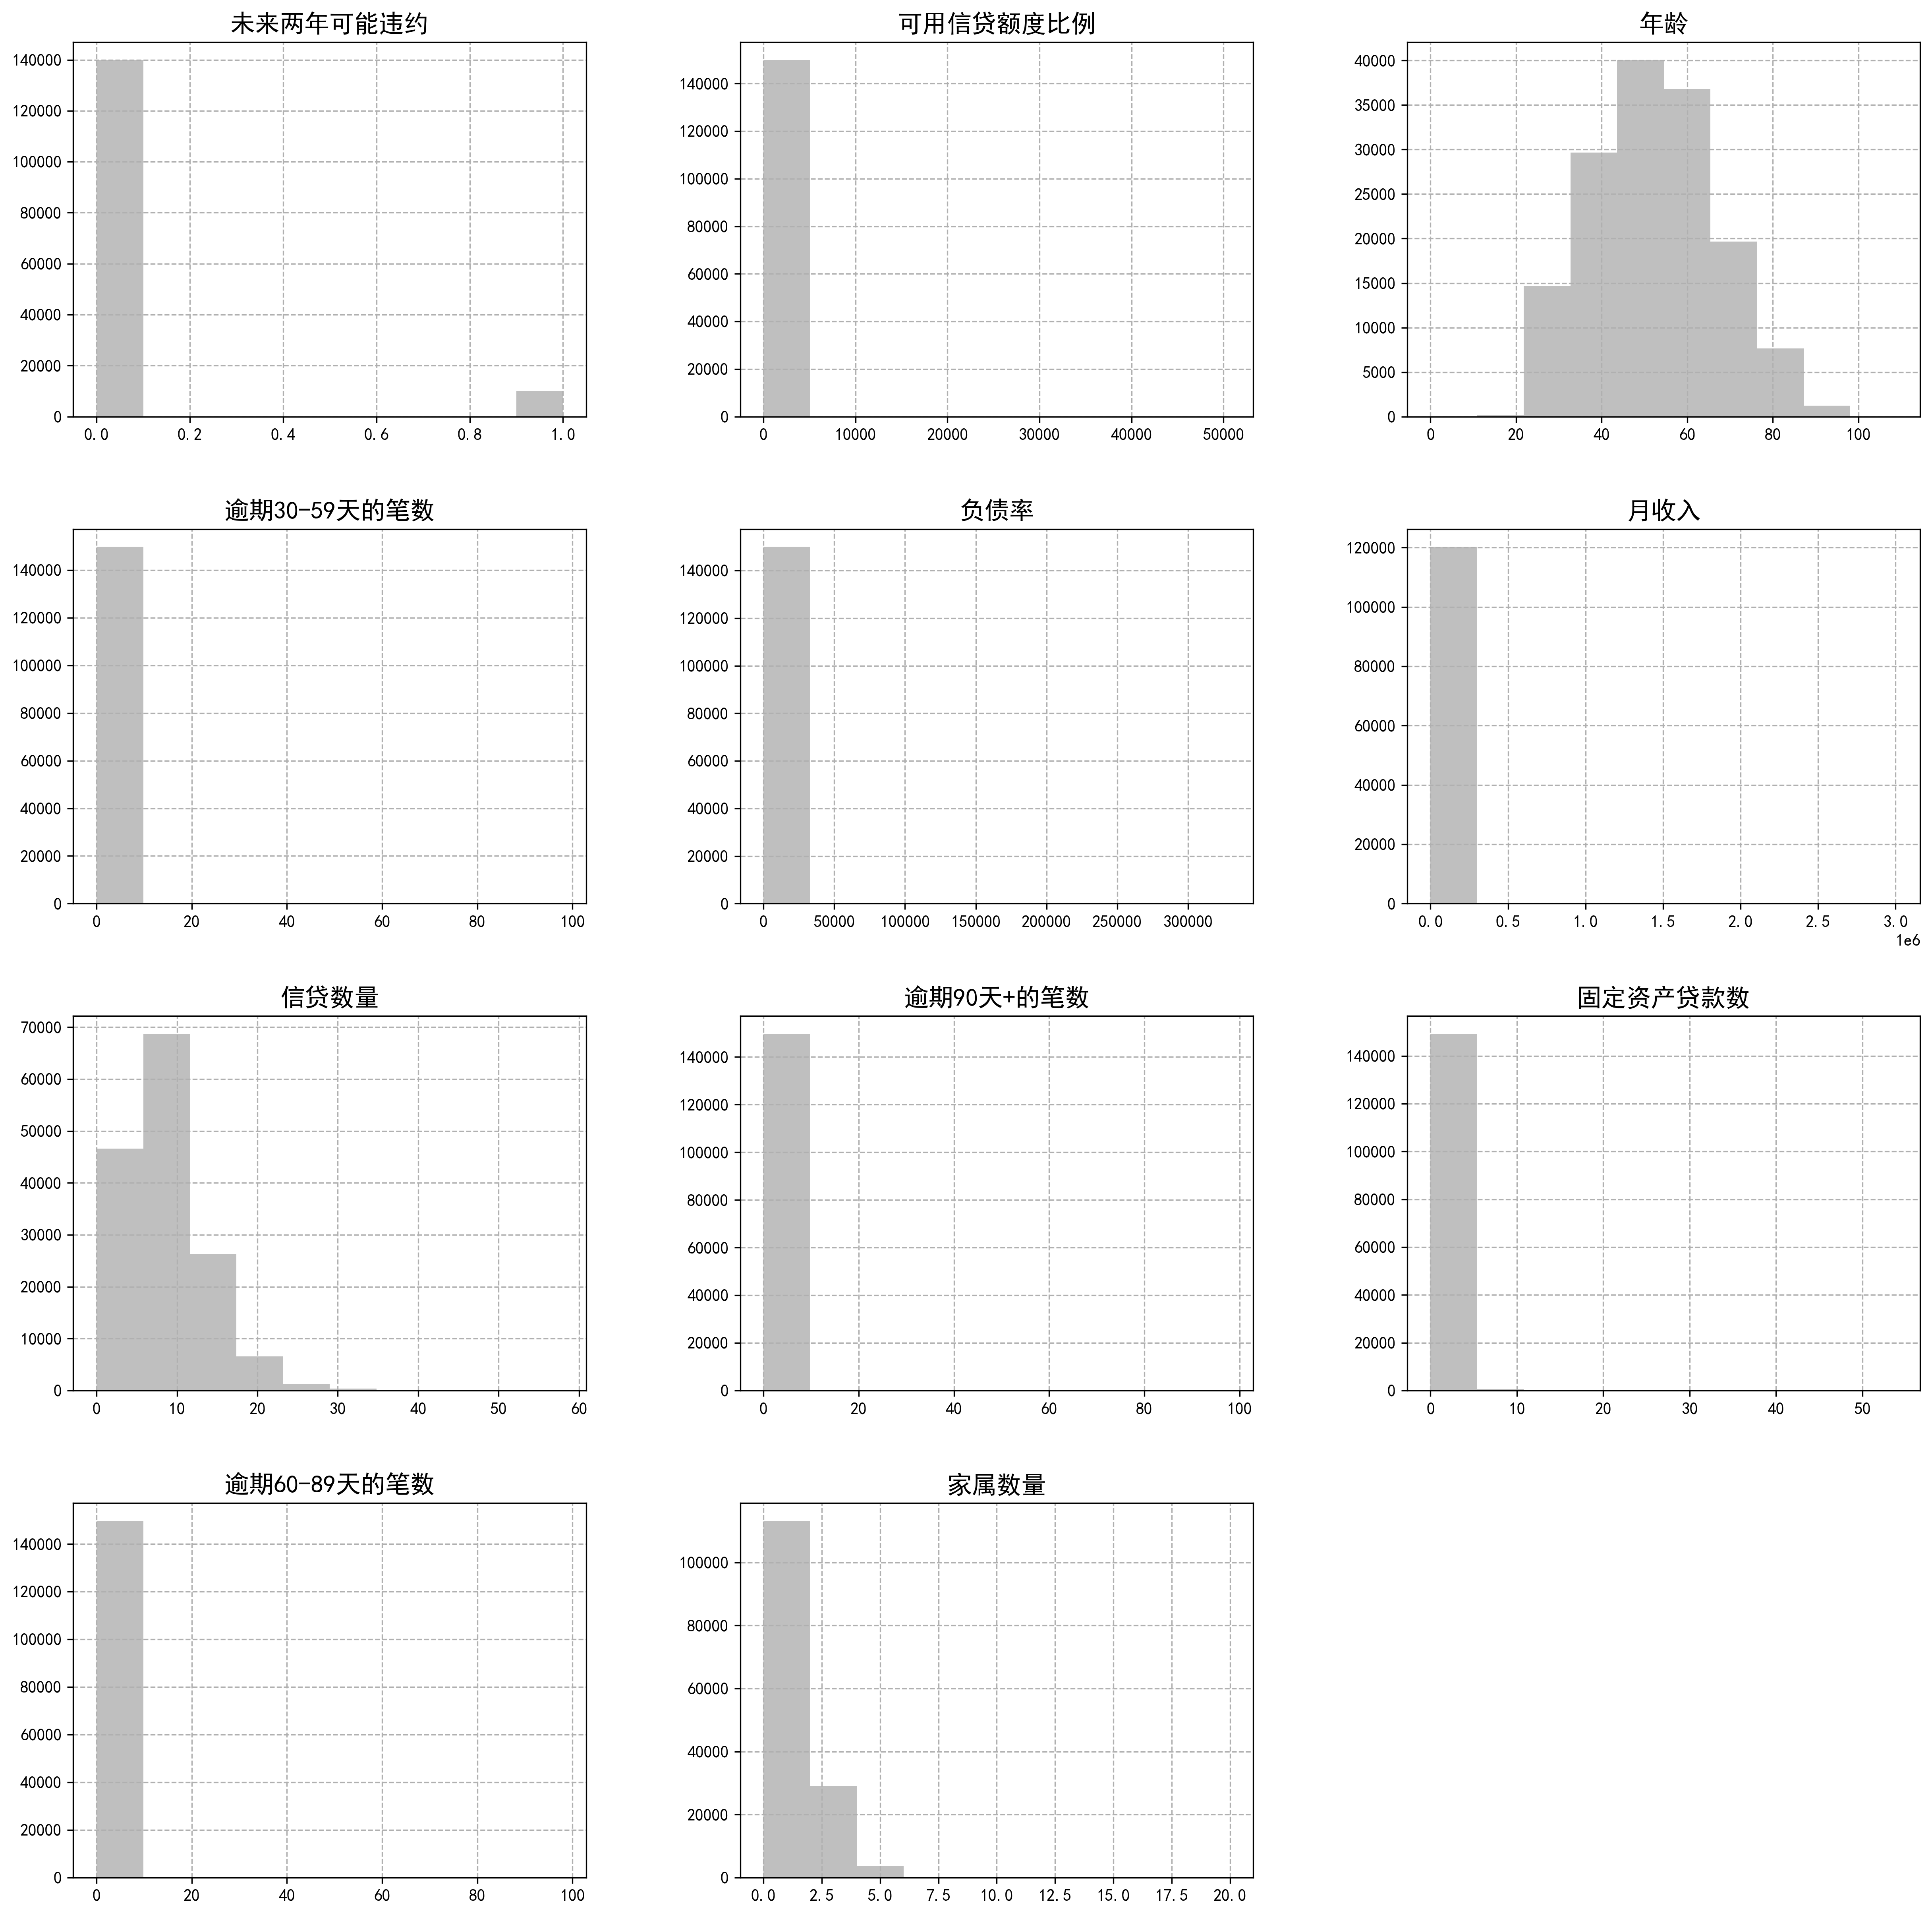

In [7]:
# 输出各字段分布情况图
# 大多数字段明显偏态，后续建模需考虑纠偏处理
plt.figure(figsize=(20, 20), dpi=300)
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # 调整图表与画布的间距问题
for n, i in enumerate(df0.columns):
    plt.subplot(4, 3, n+1)
    plt.title(i, fontsize=15)
    plt.grid(linestyle='--')
    df0[i].hist(color='grey', alpha=0.5)

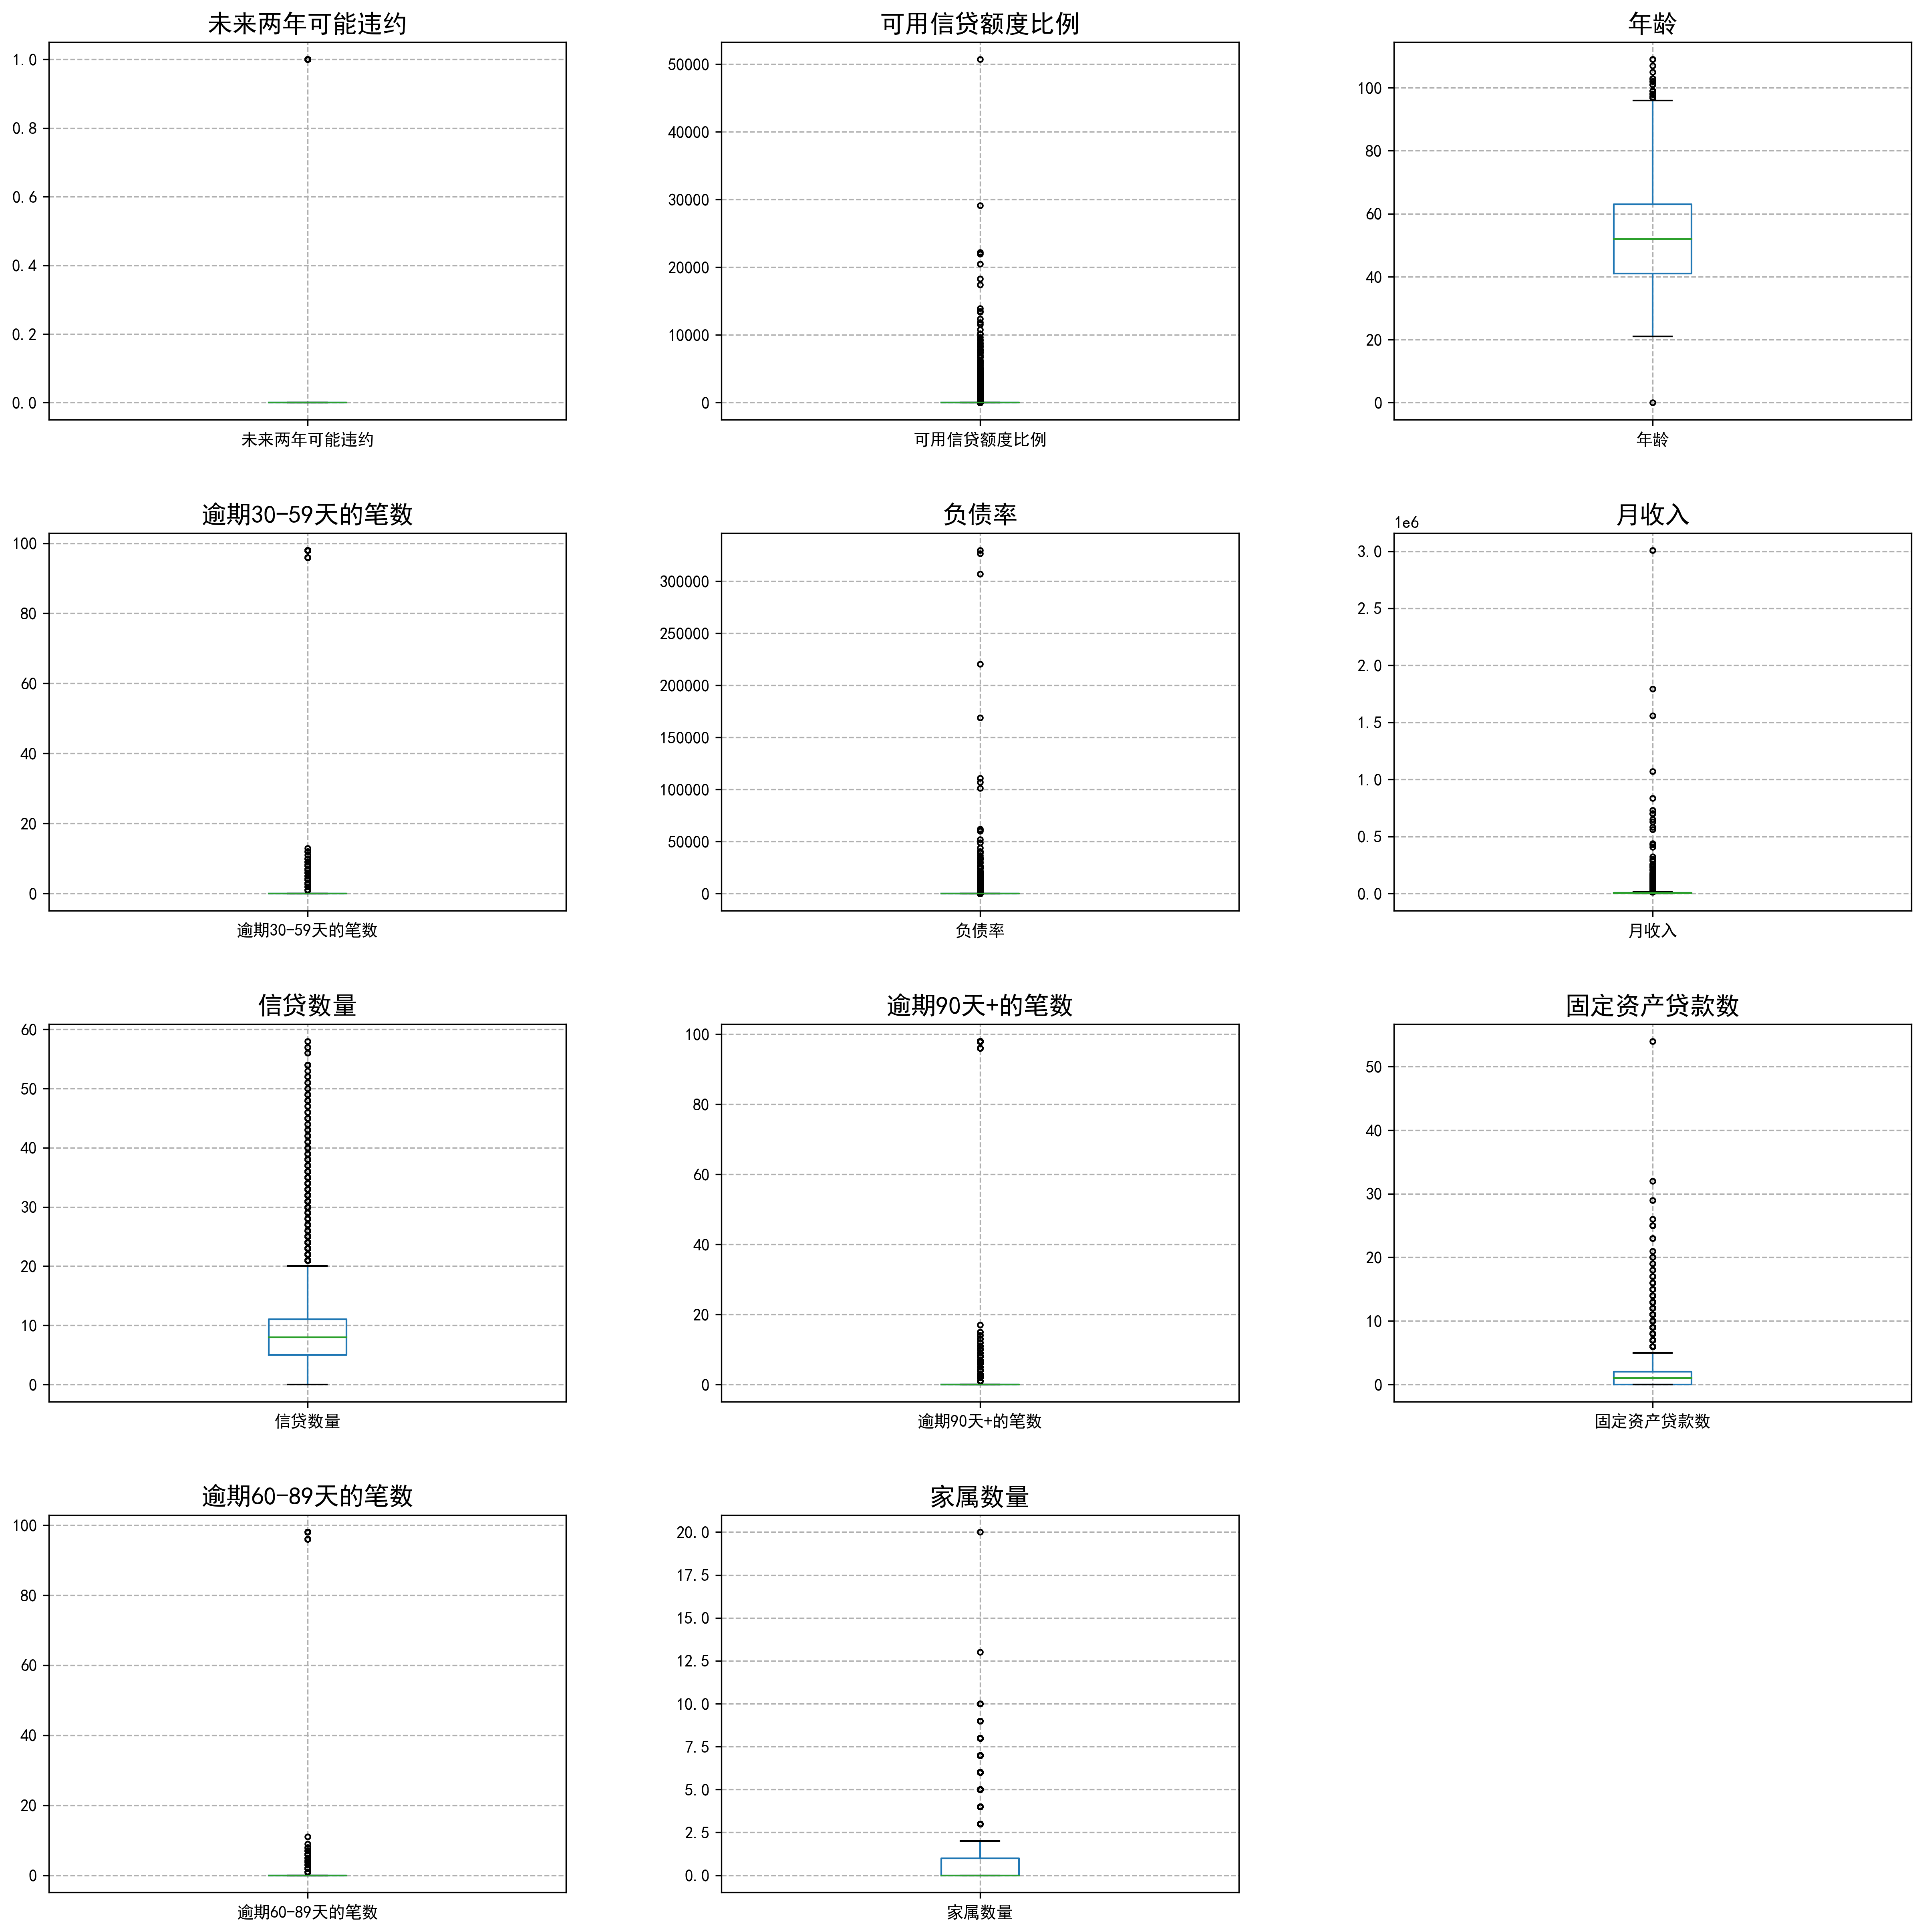

In [8]:
# 通过箱型图观察各字段异常情况
plt.figure(figsize=(20,20), dpi=300)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for n, i in enumerate(df0.columns):
    plt.subplot(4, 3, n+1)
    plt.title(i, fontsize=15)
    plt.grid(linestyle='--')
    df0[[i]].boxplot(sym='.')

- 负债率异常值（错误）较多；可用信贷额度比例 异常值（错误）
- 异常值（错误）较多，理论应小于或等于1
- “逾期30-59天的笔数”，“负债率”，“月收入”，“逾期90天+的笔数”，“固定资产贷款数”，“逾期60-89天的笔数”异常值非常多，难以观察数据分布
- 年龄方面异常值有待观察

<AxesSubplot: >

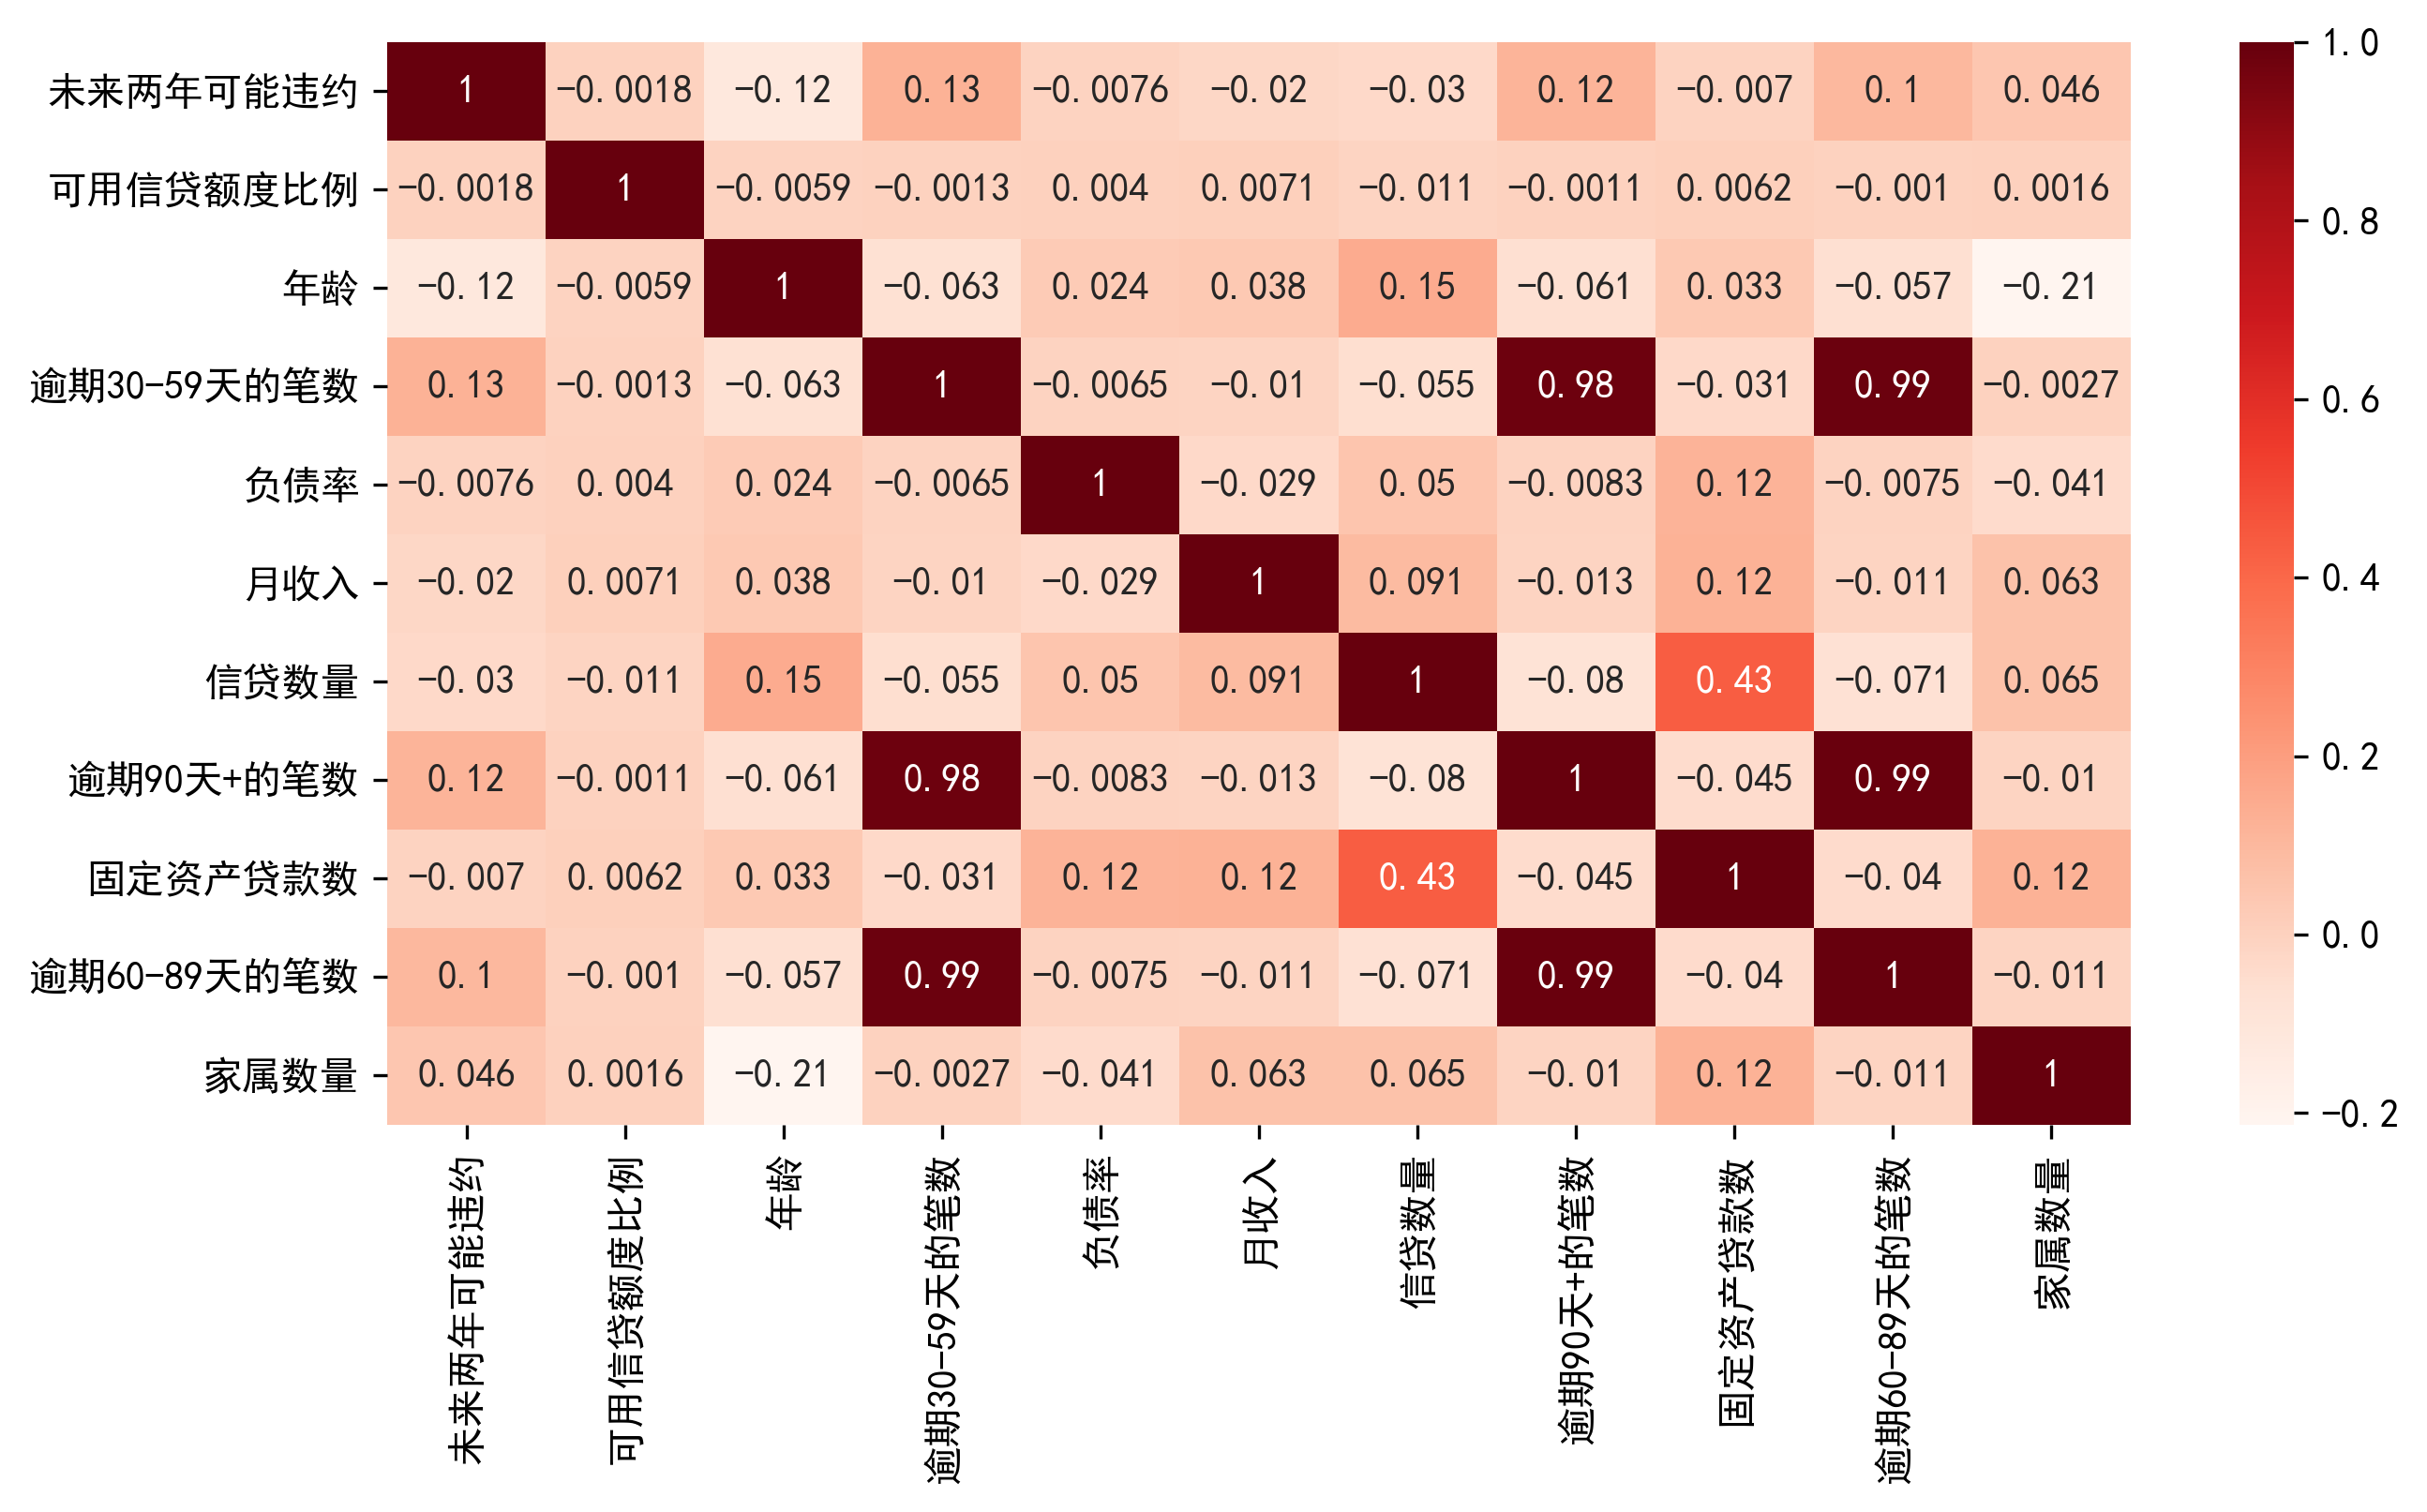

In [9]:
# 关系热力图
plt.figure(figsize=(10, 5), dpi=300)
sns.heatmap(df0.corr(), cmap='Reds', annot=True)

### 2、数据预处理与函数构建

#### 2.1 构建异常值及明显错误处理函数

In [10]:
def error_processing(df):
    '''
    异常值处理，可根据建模效果，反复调节处理方案，建议谨慎删除数据
    df: 数据源
    '''
    def show_error(df, col, whis=1.5, show=False):
        '''
        显示上下限异常值数量，可选显示示例异常数据
        df: 数据源
        col: 字段名
        whis: 默认1.5，对应1.5倍iqr
        show: 是否显示示例异常数据
        '''
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        upper_bound = df[col].quantile(0.75) + whis * iqr
        lower_bound = df[col].quantile(0.25) - whis * iqr
        print(iqr, upper_bound, lower_bound)
        print('【', col, '】上界异常值总数：', df[col][df[col] > upper_bound].count())
        if show:
            print('异常值示例：\n', df[df[col] > upper_bound].head(5).T)
        print('【', col, '】下界异常值总数：', df[col][df[col] < lower_bound].count())
        if show:
            print('异常值示例：\n', df[df[col] < lower_bound].head(5).T)
        print('-------------------')

    def drop_error(df, col):
        '''
        删除上下限异常值数量
        df: 数据源
        col: 字段名
        '''
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        upper_bound = df[col].quantile(0.75) + 1.5*iqr  # 上界
        lower_bound = df[col].quantile(0.25) - 1.5*iqr  # 下界
        data_del = df[col][(df[col] > upper_bound) | (df[col] < lower_bound)].count()
        data = df[(df[col] <= upper_bound) & (df[col] >= lower_bound)]
        print('总删除数据量：', data_del)
        return data
    
    # 计数器
    n = len(df)

    # 可用信贷额度
    # 从分布直方图可知，比例大于1的应该为错误值。
    # 错误值共3321，若剔除可能影响建模效果，剔除>=20000的数据
    show_error(df, '可用信贷额度比例')
    df = df[df.可用信贷额度比例<=20000]

    # 年龄
    # 异常值数量不多，剔除年龄大于100小于18的异常数量
    show_error(df, '年龄')
    df = df[(df['年龄']>18) & (df['年龄']<100)]

    # 逾期30-59天的笔数
    # 根据箱型图去除>80的异常数据
    show_error(df, '逾期30-59天的笔数')
    df = df[df['逾期30-59天的笔数']<80]

    # 逾期90天+的笔数
    # 根据箱型图去除>80的异常数据
    show_error(df, '逾期90天+的笔数')
    df = df[df['逾期90天+的笔数']<80]

    # 逾期60-89天的笔数
    # 根据箱型图去除>80的异常数据
    show_error(df, '逾期60-89天的笔数')
    df = df[df['逾期60-89天的笔数']<80]

    # 负债率
    # 根据箱型图去除>100000的异常数据
    show_error(df, '负债率')
    df = df[df['负债率'] < 100000]

    # 月收入
    # 根据箱型图去除 > 500000的异常数据
    show_error(df, '月收入')
    df = df[(df['月收入'] < 500000) | df.月收入.isna()]

    # 固定资产贷款数
    # 根据箱型图去除>20的异常数据
    show_error(df, '固定资产贷款数')
    df = df[df['固定资产贷款数'] < 20]

    # 家属数量
    # 根据箱型图去除>10的异常数据
    show_error(df, '家属数量')
    df = df[(df['家属数量']<12) | df.家属数量.isna()]

    # 信贷数量 - 保留异常值
    print('共删除数据 ', n - len(df), ' 条。')

#### 2.2 构建去共线性函数

In [11]:
# 3种违约情况，从上节的相关系数热力图中，可以看出有很高的共线性
# 可考虑保留'逾期90天+的笔数'，求出'逾期60-89天的笔数'/'逾期30-59天的笔数'的比值
def collineation_processing(df, col, col1, col2, name):
    '''
    去除共线性，保留一个字段，其他字段求比值
    df: 数据源
    col: 保留字段
    col1, col2: 求比值字段
    name: 新比值字段名称
    '''
    def trans2percent(row):
        if row[col2] == 0:
            return 0
        else:
            return row[col1] / row[col2]
        
    df[name] = df.apply(trans2percent, axis=1)

#### 2.3 构建缺失值处理函数

In [17]:
def missing_values_processing(df, func1=1, func2=1):
    '''
    缺失值处理
    df: 数据源
    func1: 默认为1，众数填充家属；0，去除带空值数据行。
    func2: 默认为1，众数填充月收入；0，平均数填充月收入。
    '''
    # 家属数量 - 剔除或众数填充
    if func1 == 1:
        df.loc[df.家属数量.isna(), '家属数量'] = df.家属数量.mode()[0]
    elif func1 == 0:
        df = df.dropna(subset=['家属数量'])
    else:
        print('parameter wrong!')
    # 月收入 - 剔除或均值填充
    if func2 == 1:
        df.loc[df.月收入.isna(), '月收入'] = df.月收入.mode()[0]
    elif func2 == 0:
        df.loc[df.月收入.isna(), '月收入'] = df.月收入.mean()[0]
    else:
        print('parameter wrong!')

#### 2.4 构建重采样函数

In [22]:
# 从数据初探可以发现，'未来两年可能违约'标签类别分布不均，需对样本进行重采样
def resample(df):
    '''
    使样本'未来两年可能违约'标签的0,1项可以各占一半，以提高预测效果。
    sample()可以考虑添加random_state以便生成相同样本集
    df: 数据源
    '''
    num = df['未来两年可能违约'].value_counts()[1]
    df_t = df[df.未来两年可能违约==1]
    df_f = df[df.未来两年可能违约==0].sample(frac=1)[0:num]
    df_balanced = pd.concat([df_t, df_f]).sample(frac=1).reset_index(drop=True)
    return df_balanced

### 3、数据预处理&模型训练
- 数据预处理 ==> 数据划分 ==> 模型训练及参数搜索

In [23]:
# 设【df1】为违约概率模型建模所用数据集
df1 = df0.copy()

# 异常处理
error_processing(df1)
# 去除共线性
collineation_processing(df1, '逾期90天+的笔数', '逾期60-89天的笔数', '逾期30-59天的笔数','逾期60-89天/30-59天')
# 缺失值处理
missing_values_processing(df1,func1=1,func2=1)
# 数据重采样
df_balanced = resample(df1)

# 最后将数据集划分成训练集和验证集，两者划分比例都为8:2
# 可考虑删去的列：'逾期30-59天的笔数','逾期60-89天的笔数','逾期90天+的笔数','逾期60-89天/30-59天','未来两年可能违约'
X = df_balanced.drop(['未来两年可能违约','逾期60-89天/30-59天'], axis=1)
y = df_balanced['未来两年可能违约']
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2)

# 分层K折交叉拆分器 - 用于网格搜索
cv = StratifiedKFold(n_splits=3,shuffle=True)

0.5291788055 1.35281445575 -0.7639007662499999
【 可用信贷额度比例 】上界异常值总数： 763
【 可用信贷额度比例 】下界异常值总数： 0
-------------------
22.0 96.0 8.0
【 年龄 】上界异常值总数： 45
【 年龄 】下界异常值总数： 1
-------------------
0.0 0.0 0.0
【 逾期30-59天的笔数 】上界异常值总数： 23980
【 逾期30-59天的笔数 】下界异常值总数： 0
-------------------
0.0 0.0 0.0
【 逾期90天+的笔数 】上界异常值总数： 8068
【 逾期90天+的笔数 】下界异常值总数： 0
-------------------
0.0 0.0 0.0
【 逾期60-89天的笔数 】上界异常值总数： 7335
【 逾期60-89天的笔数 】下界异常值总数： 0
-------------------
0.69370008625 1.910257783625 -0.8645425613750002
【 负债率 】上界异常值总数： 31271
【 负债率 】下界异常值总数： 0
-------------------
4850.0 15525.0 -3875.0
【 月收入 】上界异常值总数： 4876
【 月收入 】下界异常值总数： 0
-------------------
2.0 5.0 -3.0
【 固定资产贷款数 】上界异常值总数： 793
【 固定资产贷款数 】下界异常值总数： 0
-------------------
1.0 2.5 -1.5
【 家属数量 】上界异常值总数： 13326
【 家属数量 】下界异常值总数： 0
-------------------
共删除数据  322  条。


In [25]:
# 分类模型性能查看函数
def perfomance_clf(model, X, y, name=None):
    y_predict = model.predict(X)
    if name:
        print(name, ':')
    print(f'accuracy score is: {accuracy_score(y,y_predict)}')
    print(f'precision score is: {precision_score(y,y_predict)}')
    print(f'recall score is: {recall_score(y,y_predict)}')
    print(f'auc: {roc_auc_score(y,y_predict)}')
    print('- - - - - - ')

#### 3.1 逻辑回归模型

In [28]:
# 参数设定
log_params = {'penalty': ['l1', 'l2'], 'C': [0.001*10**i for i in range(0, 7)]}
# 参数搜索
log_gridsearch = GridSearchCV(LogisticRegression(solver='liblinear'), log_params, cv=cv,
                              n_jobs=-1, scoring='roc_auc', verbose=2, refit=True)
# 工作流管道
pipe_log = Pipeline([
    ('sc', StandardScaler()),  # 标准化Z-score
    ('pow_trans', PowerTransformer()),   # 纠偏
    ('log_grid', log_gridsearch)
])
# 搜索参数并训练模型
pipe_log.fit(xtrain, ytrain)
# 最佳参数组合
print(pipe_log.named_steps['log_grid'].best_params_)
# 训练集性能指标
perfomance_clf(pipe_log, xtrain, ytrain, name='train')
# 测试集性能指标
perfomance_clf(pipe_log, xtest, ytest, name='test')

Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'C': 1000.0, 'penalty': 'l2'}
train :
accuracy score is: 0.7755750888348607
precision score is: 0.8027060610244374
recall score is: 0.7281152160300564
auc: 0.775365949623767
- - - - - - 
test :
accuracy score is: 0.7656444776863625
precision score is: 0.8019747668678003
recall score is: 0.7163155316021558
auc: 0.7665334003188444
- - - - - - 


In [29]:
# 交叉验证查看平均分数
cross_val_score(pipe_log, xtrain, ytrain, cv=3, scoring='roc_auc').mean()

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits


0.8580755044248091

#### 3.2 随机森林分类模型

In [30]:
# 随机森林分类模型
rf_clf = RandomForestClassifier(criterion='gini', n_jobs=-1, n_estimators=1000)
# 参数设定
rf_grid_params = {'max_features': ['auto'], 'max_depth': [6, 9]}
# 参数搜索
rf_gridsearch = GridSearchCV(rf_clf, rf_grid_params, cv=cv, n_jobs=-1, scoring='roc_auc', verbose=10, refit=True)
# 工作流管道
pipe_rf = Pipeline([
    ('sc', StandardScaler()),
    ('pow_trans', PowerTransformer()),
    ('rf_grid', rf_gridsearch)
])
# 搜索参数并训练模型
pipe_rf.fit(xtrain, ytrain)
# 最佳参数组合
print(pipe_rf.named_steps['rf_grid'].best_params_)
# 训练集性能指标
perfomance_clf(pipe_rf, xtrain, ytrain, name='train')
# 测试集性能指标
perfomance_clf(pipe_rf, xtest, ytest, name='test')

Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'max_depth': 9, 'max_features': 'auto'}
train :
accuracy score is: 0.81834050246244
precision score is: 0.8258578588870326
recall score is: 0.8047589229805886
auc: 0.8182806531486855
- - - - - - 
test :
accuracy score is: 0.7706307653951633
precision score is: 0.7795511221945137
recall score is: 0.7658010779029887
auc: 0.770717797834743
- - - - - - 


In [31]:
# 注意，交叉验证查看平均分数（由于管道会反复搜索参数，会较耗时）
cross_val_score(pipe_rf, xtrain, ytrain, cv=3, scoring='roc_auc').mean()

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits


0.8634227631630074

#### 3.3 xgboost模型

In [32]:
# xgboost 模型
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            n_job=-1,
                            booster='gbtree',
                            n_estimators=1000,
                            learning_rate=0.01)
# 参数设定
xgb_params = {
    'max_depth': [6, 9],    # 注意参数设置，数量多了会更加耗时
    'subsample': [0.6, 0.9],
    'colsample_bytree': [0.5, 0.6],
    'reg_alpha': [0.05, 0.1]
}
# 参数搜索
xgb_gridsearch = GridSearchCV(xgb_clf, xgb_params, cv=cv, n_jobs=-1, 
                              scoring='roc_auc', verbose=10, refit=True)
# 工作流管道
pipe_xgb = Pipeline([
    ('sc', StandardScaler()),
    ('pow_trans', PowerTransformer()),
    ('xgb_grid', xgb_gridsearch)
])
# 搜索参数并训练模型
pipe_xgb.fit(xtrain, ytrain)
# 最佳参数组合
print(pipe_xgb.named_steps['xgb_grid'].best_params_)
# 训练集性能指标
perfomance_clf(pipe_xgb, xtrain, ytrain, name='train')
# 测试集性能指标
perfomance_clf(pipe_xgb, xtest, ytest, name='test')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[20:21:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_job" } are not used.

{'colsample_bytree': 0.5, 'max_depth': 6, 'reg_alpha': 0.1, 'subsample': 0.6}
train :
accuracy score is: 0.8253849510629013
precision score is: 0.8356643356643356
recall score is: 0.808140262993112
auc: 0.825308959699138
- - - - - - 
test :
accuracy score is: 0.7738718524058839
precision score is: 0.7837837837837838
recall score is: 0.7672709456148946
auc: 0.773990802756686
- - - - - - 


In [33]:
# 注意，交叉验证查看平均分数（由于管道会反复搜索参数，会很耗时）
cross_val_score(pipe_xgb, xtrain, ytrain, cv=3, scoring='roc_auc').mean()

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[20:23:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_job" } are not used.

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[20:25:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_job" } are not used.

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[20:27:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_job" } are not used.



0.8645526719612412

Index(['可用信贷额度比例', '年龄', '逾期30-59天的笔数', '负债率', '月收入', '信贷数量', '逾期90天+的笔数',
       '固定资产贷款数', '逾期60-89天的笔数', '家属数量'],
      dtype='object')

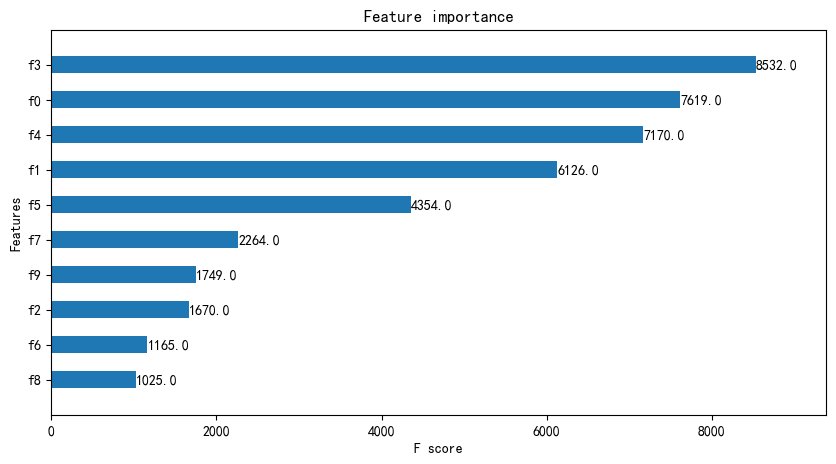

In [34]:
# 查看字段相对xgboost模型的重要程度
# 一般显示['可用信贷额度比例', '年龄', '负债率', '月收入', '信贷数量'] 这些字段比较重要
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
xgb.plot_importance(pipe_xgb.named_steps['xgb_grid'].best_estimator_, 
                    max_num_features=40, height=0.5, grid=False, ax=ax)
xtrain.columns

### 4、预测并生成结果
- 测试集读取与生成结果文件

In [35]:
#  预测集数据读取与处理
dftest = pd.read_csv('./data/cs-test.csv').drop('Unnamed: 0',axis=1)
dftest.rename(columns = {'SeriousDlqin2yrs':'未来两年可能违约', 'RevolvingUtilizationOfUnsecuredLines':'可用信贷额度比例', 'age':'年龄',
      'NumberOfTime30-59DaysPastDueNotWorse':'逾期30-59天的笔数', 'DebtRatio':'负债率', 'MonthlyIncome':'月收入',
      'NumberOfOpenCreditLinesAndLoans':'信贷数量', 'NumberOfTimes90DaysLate':'逾期90天+的笔数',
      'NumberRealEstateLoansOrLines':'固定资产贷款数', 'NumberOfTime60-89DaysPastDueNotWorse':'逾期60-89天的笔数',
      'NumberOfDependents':'家属数量'},inplace=True)
dftest.loc[dftest.家属数量.isna(),'家属数量'] = df1.家属数量.mode()[0]
dftest.loc[dftest.月收入.isna(),'月收入'] = df1.月收入.mode()[0]

In [36]:
# 以xgboost模型预测，生成csv结果文件
result = pipe_xgb.predict_proba(dftest.drop('未来两年可能违约',axis=1))
result_ = [[n+1,i] for n,i in enumerate(result[:,1])]
df_result = pd.DataFrame(result_,columns=['Id','Probability'])
df_result.to_csv('sampleEntry.csv',index=False)

### 5、模型保存

In [37]:
# 模型保存方法
import pickle
with open('pipe_log.pickle','wb') as f:
    pickle.dump(pipe_log,f)
with open('pipe_log.pickle','rb') as f:
    clf = pickle.load(f)